In [207]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import json
import time
import os

In [177]:
CSV_OPTIONS = {
    "encoding": "ISO-8859-1",
    "na_values": [" "]
}
# Condo value data: https://data.cityofnewyork.us/City-Government/DOF-Condominium-Comparable-Rental-Income-in-NYC/9ck6-2jew
cvData = pd.read_csv("external_data/DOF_Condominium_Comparable_Rental_Income_in_NYC.csv", **CSV_OPTIONS)
cvData.head()

,Boro-Block-Lot,Condo Section,Address,Neighborhood,Building Classification,Total Units,Year Built,Gross SqFt,Estimated Gross Income,Gross Income per SqFt,...,Gross SqFt 3,Estimated Gross Income 3,Gross Income per SqFt 3,Estimated Expense 3,Expense per SqFt 3,Net Operating Income 3,Full Market Value 3,Market Value per SqFt 3,Distance from Condo in miles 2,Report Year
0,1-00007-7501,0735-R1,1 COENTIES SLIP,FINANCIAL,R9-CONDOMINIUM,42,1920.0,36500,1216180,33.32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
1,1-00008-7501,1822-R1,39 WHITEHALL STREET,FINANCIAL,R4-CONDOMINIUM,78,1985.0,126420,6823366,53.97,...,111184.0,5147164.0,46.29,1445424.0,13.00,3701740.0,27948000.0,251.37,0.43,2012
2,1-00015-7501,1025-R1,17 BATTERY PLACE,FINANCIAL,RR-CONDOMINIUM,500,NaN,554174,16609710,29.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012
3,1-00015-7502,1557-R1,20 WEST STREET,FINANCIAL,R4-CONDOMINIUM,282,1930.0,249076,8946810,35.92,...,303086.0,9699622.0,32.00,2542914.0,8.39,7156708.0,54033000.0,178.28,0.19,2012
4,1-00016-7501,0308-R1,377 RECTOR PLACE,TRIBECA,R4-CONDOMINIUM,239,1985.0,219495,7072129,32.22,...,230766.0,6196187.0,26.85,1722965.0,7.47,4473222.0,33740000.0,146.21,0.00,2012


In [178]:
# Rearrange columns
cvData.columns
keep_cols = [c for c in cvData.columns if "distance" not in c.lower()]
cvData = cvData[keep_cols]
cvData.drop(["Condo Section"], axis=1, inplace=True)
end_index = list(cvData.columns).index("Market Value per SqFt")
cols = cvData.columns
sets = [cvData[cols[0:14]], cvData[cols[14:28]], cvData[cols[28:42]], cvData[cols[42:-1]]]
new_col_names = ["boro_block_lot", "address", "neighbourhood", "building_classification", "total_units", "year_built", "gross_sqft", "estimated_gross_income", "gross_income_per_sqft", "estimated_expense", "expense_per_sqft", "operating_income", "market_value", "market_value_per_sqft"]
for s in sets:
    s.columns = new_col_names
    s.insert(loc=0, column="report_year", value=cvData["Report Year"])
df = pd.concat(sets)
#df = sets[0]
df.drop(["neighbourhood", "building_classification"], axis=1, inplace=True)
df = df.drop_duplicates(subset=["boro_block_lot", "report_year"])
df.head()


,report_year,boro_block_lot,address,total_units,year_built,gross_sqft,estimated_gross_income,gross_income_per_sqft,estimated_expense,expense_per_sqft,operating_income,market_value,market_value_per_sqft
0,2012,1-00007-7501,1 COENTIES SLIP,42.0,1920.0,36500.0,1216180.0,33.32,293460.0,8.04,922720.0,7156000.0,196.05
1,2012,1-00008-7501,39 WHITEHALL STREET,78.0,1985.0,126420.0,6823366.0,53.97,1638934.0,12.96,5184432.0,39143000.0,309.63
2,2012,1-00015-7501,17 BATTERY PLACE,500.0,NaN,554174.0,16609710.0,29.97,3668467.0,6.62,12941243.0,93405000.0,168.55
3,2012,1-00015-7502,20 WEST STREET,282.0,1930.0,249076.0,8946810.0,35.92,2744818.0,11.02,6201992.0,46825007.0,187.99
4,2012,1-00016-7501,377 RECTOR PLACE,239.0,1985.0,219495.0,7072129.0,32.22,1169908.0,5.33,5902221.0,44562006.0,203.02


In [179]:
df.dropna(subset=["boro_block_lot", "market_value", "market_value_per_sqft"], axis=0, inplace=True)
print("Borough codes: ", df.boro_block_lot.apply(lambda x: str(x).split("-")[0]).unique()) # 1-5 for nyc boroughs
df.insert(loc=0, column="lot", value=df.boro_block_lot.apply(lambda x: x.split("-")[2]))
df.insert(loc=0, column="block", value=df.boro_block_lot.apply(lambda x: x.split("-")[1]))
df.insert(loc=0, column="boro", value=df.boro_block_lot.apply(lambda x: x.split("-")[0]))
df.drop(["boro_block_lot"], axis=1, inplace=True)

# Look at Bronx only for now, #2
#df = df[df.boro == '2']
df.head()

Borough codes:  ['1' '2' '3' '4' '5']


,boro,block,lot,report_year,address,total_units,year_built,gross_sqft,estimated_gross_income,gross_income_per_sqft,estimated_expense,expense_per_sqft,operating_income,market_value,market_value_per_sqft
0,1,00007,7501,2012,1 COENTIES SLIP,42.0,1920.0,36500.0,1216180.0,33.32,293460.0,8.04,922720.0,7156000.0,196.05
1,1,00008,7501,2012,39 WHITEHALL STREET,78.0,1985.0,126420.0,6823366.0,53.97,1638934.0,12.96,5184432.0,39143000.0,309.63
2,1,00015,7501,2012,17 BATTERY PLACE,500.0,NaN,554174.0,16609710.0,29.97,3668467.0,6.62,12941243.0,93405000.0,168.55
3,1,00015,7502,2012,20 WEST STREET,282.0,1930.0,249076.0,8946810.0,35.92,2744818.0,11.02,6201992.0,46825007.0,187.99
4,1,00016,7501,2012,377 RECTOR PLACE,239.0,1985.0,219495.0,7072129.0,32.22,1169908.0,5.33,5902221.0,44562006.0,203.02


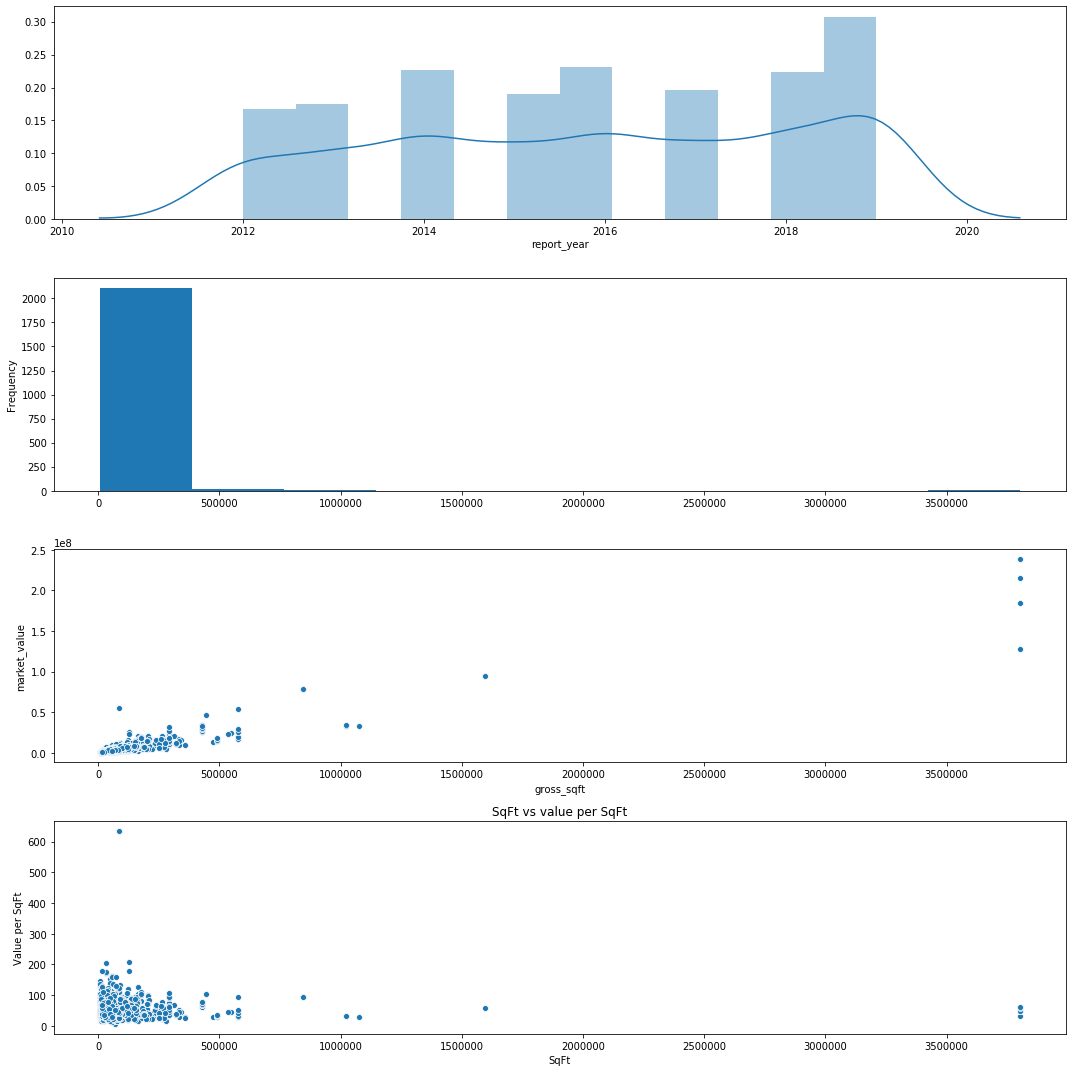

In [103]:
# Samples by year
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15,15))
sns.distplot(df.report_year, ax=ax[0])
plt.title("Valuations by year density")
plt.xlabel("Year")

df.gross_sqft.plot(kind="hist", ax=ax[1])
plt.title("Property floorspace density")
plt.xlabel("Space SqFt")

sns.scatterplot(df.gross_sqft, df.market_value, ax=ax[2])
plt.title("SqFt vs value")
plt.xlabel("SqFt")
plt.ylabel("Value")

sns.scatterplot(df.gross_sqft, df.market_value_per_sqft, ax=ax[3])
plt.title("SqFt vs value per SqFt")
plt.xlabel("SqFt")
plt.ylabel("Value per SqFt")

plt.tight_layout()

In [104]:
t = df.sort_values(by=["block", "address", "report_year"])
v = t.address.value_counts()
t = t[t.address.isin(v.index[v.gt(3)])]
t.head()

,boro,block,lot,report_year,address,total_units,year_built,gross_sqft,estimated_gross_income,gross_income_per_sqft,estimated_expense,expense_per_sqft,operating_income,market_value,market_value_per_sqft
4310,2,02295,7501,2013,85 WILLIS AVENUE,419.0,2009.0,430213.0,7558842.0,17.57,3889126.0,9.04,3669716.0,25934000.0,60.28
7127,2,02295,7501,2014,85 WILLIS AVENUE,419.0,2009.0,430213.0,7563145.0,17.58,3785874.0,8.80,3777271.0,26725000.0,62.12
9359,2,02295,7501,2015,85 WILLIS AVENUE,419.0,2009.0,430213.0,7644885.0,17.77,3639602.0,8.46,4005283.0,29179999.0,67.83
11952,2,02295,7501,2016,85 WILLIS AVENUE,419.0,2009.0,430213.0,8621469.0,20.04,4796875.0,11.15,3824594.0,29413999.0,68.37
14901,2,02295,7501,2017,85 WILLIS AVENUE,419.0,2009.0,430213.0,8165443.0,18.98,4233296.0,9.84,3932147.0,31078998.0,72.24


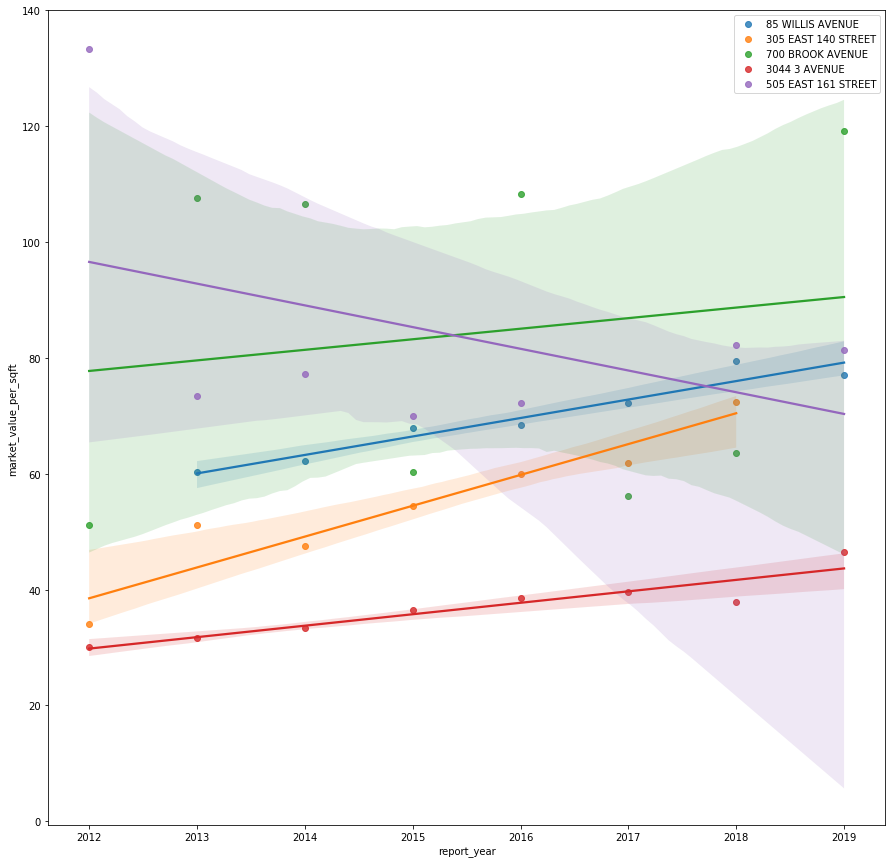

In [105]:
fig, ax = plt.subplots(figsize=(15, 15))
test_plots = t.address.unique()[:5]
for ts in test_plots:
    plot = t[t.address == ts]
    sns.regplot(plot.report_year, plot.market_value_per_sqft, ax=ax, label=ts)
plt.legend()

In [283]:
tmpdf = df.copy()

In [284]:
geoids = []
files = os.listdir("geocode_results/")
names = ["address", "match", "match_type", "full_address", "lat_long", "geoid", "waste1", "waste2", "waste3", "waste4", "waste5"]

for f in files:
    if f.endswith(".csv"):
        geoids.append(pd.read_csv(os.path.join("geocode_results/", f), names=names))
        
geoids = pd.concat(geoids)
geoids = geoids[["address", "geoid", "lat_long"]]
geoids.address = geoids.address.apply(lambda x: str(x).split(",")[0])
tmpdf = tmpdf.merge(geoids, on="address", how="inner")
tmpdf = tmpdf.dropna().reset_index()

In [269]:
tmpdf.to_pickle("condo_prices_report.pkl")

In [ ]:
# 3D plot of data per year per 

In [299]:
addresses = tmpdf.address.unique()
address_geoid = {}
i = 0

for address in addresses:
    i += 1
    url1 = "https://geocoding.geo.census.gov/geocoder/geographies/address?street="
    url2 = "&city=New+York+City&state=NY&benchmark=Public_AR_Census2010&vintage=Census2010_Census2010&layers=14&format=json"
    street = address.replace(" ", "+")
    
    url = url1 + street + url2
    
    try:
        result = requests.get(url).json()
    except:
        time.sleep(0.5)
        result = requests.get(url).json()
    try:
        address_geoid[address] = result["result"]["addressMatches"][0]["geographies"]["Census Blocks"][0]
    except Exception as e:
        print(e)
        pass
    if i % 100 == 0:
        print("Completed ", i, " of ", len(addresses))

Completed  100  of  4418
Completed  200  of  4418
Completed  300  of  4418
list index out of range
Completed  400  of  4418
Completed  500  of  4418
Completed  600  of  4418
Completed  700  of  4418
Completed  800  of  4418
list index out of range
Completed  900  of  4418
list index out of range
Completed  1000  of  4418
Completed  1100  of  4418
Completed  1200  of  4418
list index out of range
list index out of range
Completed  1300  of  4418
list index out of range
Completed  1400  of  4418
list index out of range
Completed  1500  of  4418
list index out of range
list index out of range
Completed  1600  of  4418
list index out of range
Completed  1700  of  4418
list index out of range
list index out of range
list index out of range
list index out of range
Completed  1800  of  4418
Completed  1900  of  4418
Completed  2000  of  4418
Completed  2100  of  4418
Completed  2200  of  4418
list index out of range
Completed  2300  of  4418
Completed  2400  of  4418
list index out of range
l

In [301]:
for index, row in tmpdf.iterrows():
    tmpdf.loc[index, "geoid"] = address_geoid[row["address"]]

ValueError: Must have equal len keys and value when setting with an iterable

In [317]:
for index, row in tmpdf.iterrows():
    try:
        tmpdf.loc[index, "geoid"] = addgeoid[row["address"]]
    except:
        tmpdf.loc[index, "geoid"] = np.nan

In [324]:
tmpdf.dropna(inplace=True)

In [326]:
tmpdf.to_pickle("condo_prices_report.pkl")